# Royalty Prediction per Artist using Multivariate SARIMAX
### Master's Thesis in Data Science
This analysis applies a multivariate SARIMAX model, including exogenous variables such as social media followers and sentiment.

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Dataset Loading

In [16]:
file_git = 'https://raw.githubusercontent.com/florfede/royalty-forecasting-timeseries/refs/heads/main/data/dataset.csv'
df = pd.read_csv(file_git)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.head()

,artist_id,date,royalties,instagram_followers,twitter_followers,track_release,sentiment,mentions_followers,num_posts,num_comments,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_mentions_followers_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


## SARIMAX Training and Prediction with Exogenous Variables

  0%|          | 0/15 [00:00<?, ?it/s]

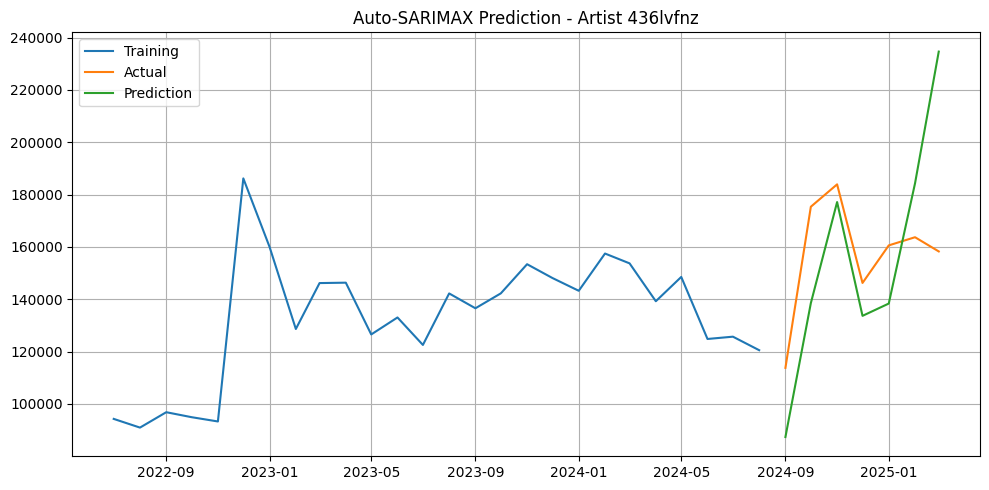

In [17]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

results = []
forecast_output = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("date")
    group.set_index("date", inplace=True)

    y = group["royalties"].asfreq('MS')
    X = group[[
    "instagram_followers", 
    "twitter_followers", 
    "track_release", 
    "sentiment", 
    "mentions_followers", 
    "num_posts", 
    "num_comments", 
    "mean_royalties_6m", 
    "std_instagram_followers_6m", 
    "growth_twitter_followers", 
    "growth_instagram_followers", 
    "sum_track_releases_6m", 
    "mean_sentiment_3m", 
    "sum_mentions_followers_3m", 
    "month"
    ]].asfreq('MS')

    if len(y) < 10:
        continue

    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]
    X_train, X_test = X[:train_size], X[train_size:]

    try:
        # Encontrar mejor orden con auto_arima (sin seasonal)
        auto_model = auto_arima(
            y_train,
            exogenous=X_train,
            seasonal=False,
            trace=False,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore",
            max_order=5
        )

        best_order = auto_model.order  # (p,d,q)

        # Crear modelo SARIMAX con ese orden y exógenas
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=best_order,
            seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=len(y_test), exog=X_test)

        for date, y_real, y_pred in zip(y_test.index, y_test, forecast):
            forecast_output.append({
                "artist_id": artist_id,
                "date": date,
                "royalties_real": y_real,
                "royalties_pred": y_pred,
                "model": "Auto SARIMAX"
            })

        mse = mean_squared_error(y_test, forecast)
        mae = mean_absolute_error(y_test, forecast)
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(y_test, forecast)

        results.append({
            "Artist_ID": artist_id,
            "Model": "SARIMAX",
            "MSE": mse,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape
        })

        if len(results) == 1:
            plt.figure(figsize=(10,5))
            plt.plot(y_train.index, y_train, label='Training')
            plt.plot(y_test.index, y_test, label='Actual')
            plt.plot(y_test.index, forecast, label='Prediction')
            plt.title(f'Auto-SARIMAX Prediction - Artist {artist_id}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        results.append({
            "Artist_ID": artist_id,
            "Model": f"Error: {e}",
            "MSE": None,
            "MAE": None,
            "RMSE": None,
            "MAPE": None
        })


# Individual Visualizations per Artist

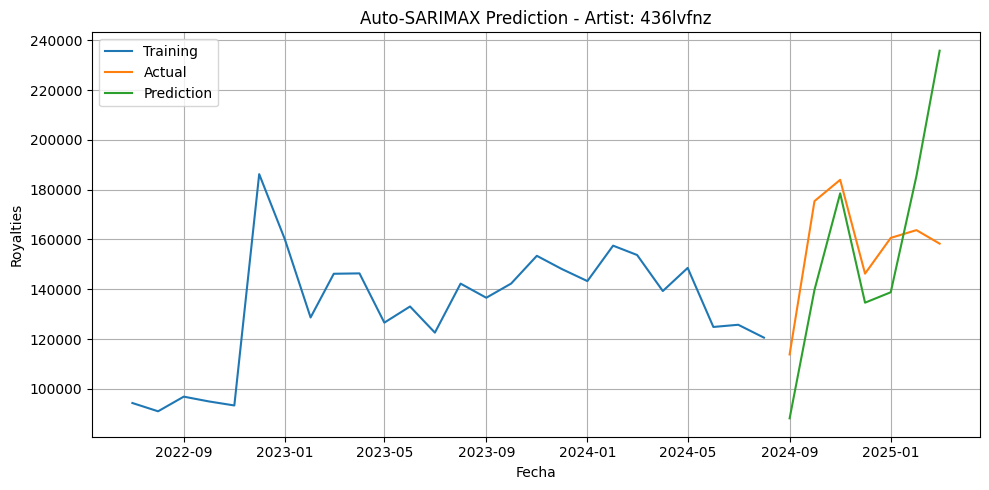

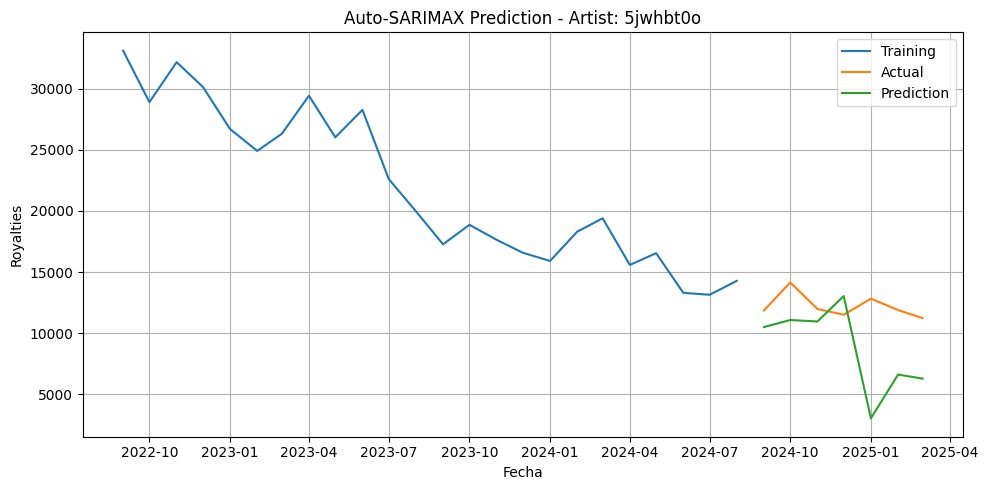

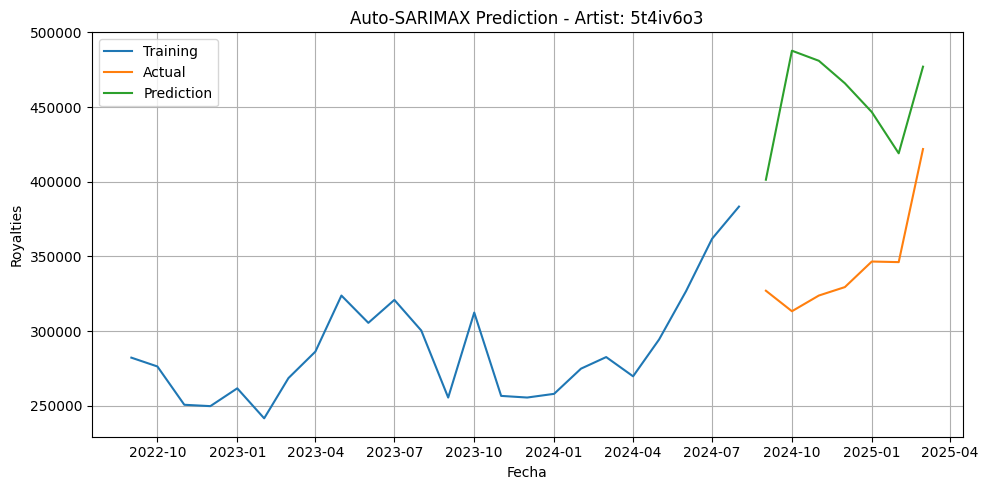

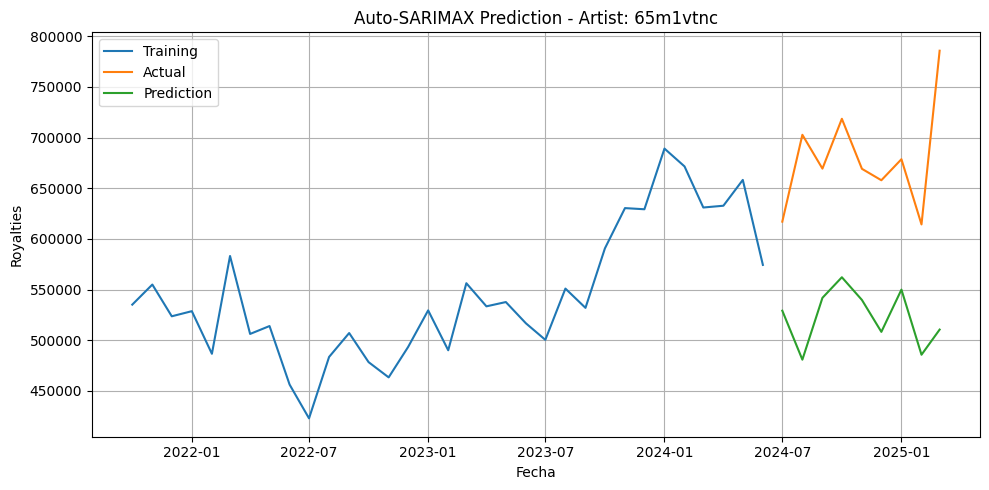

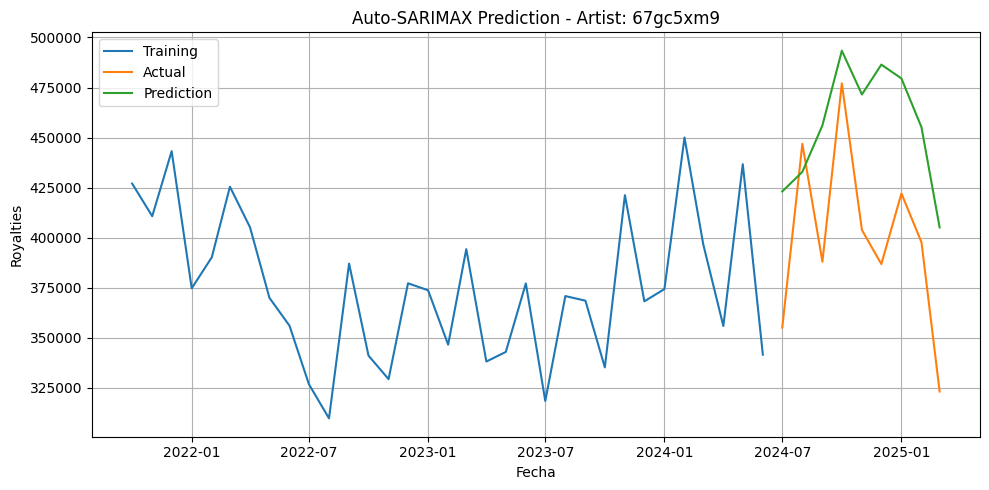

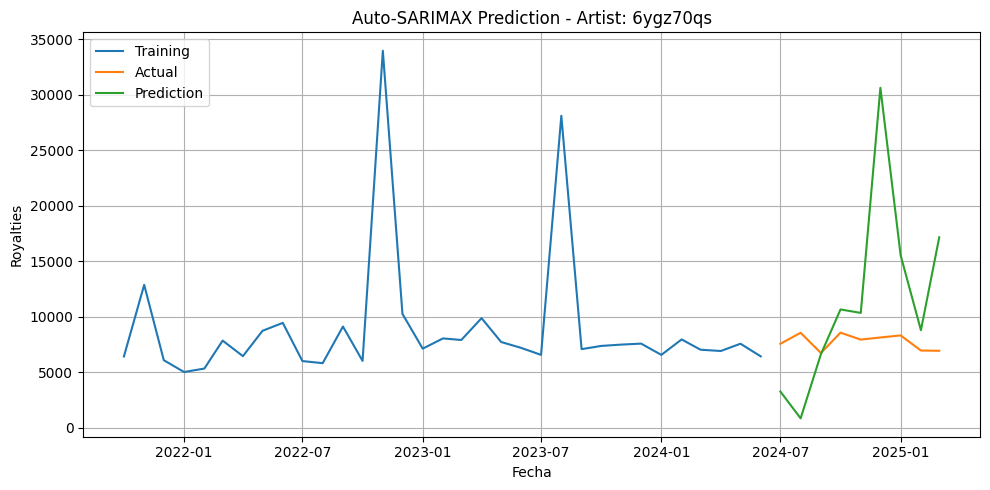

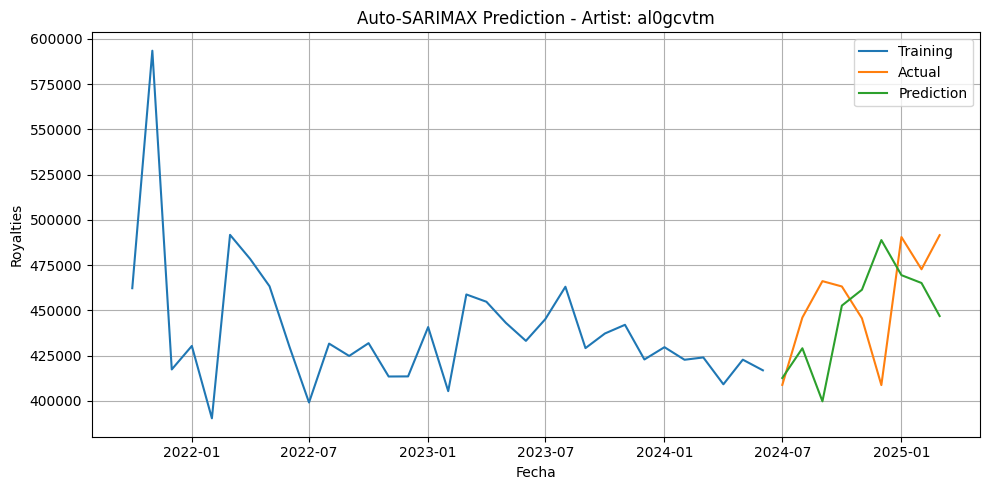

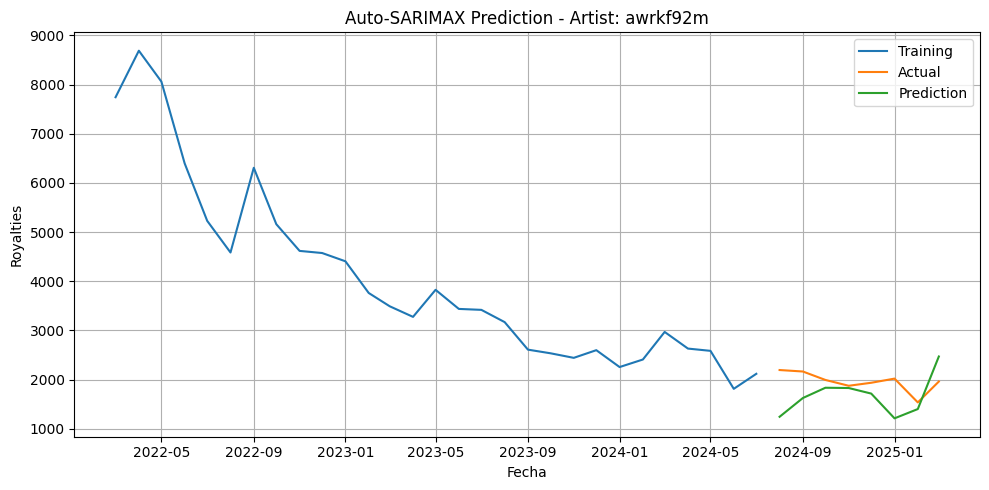

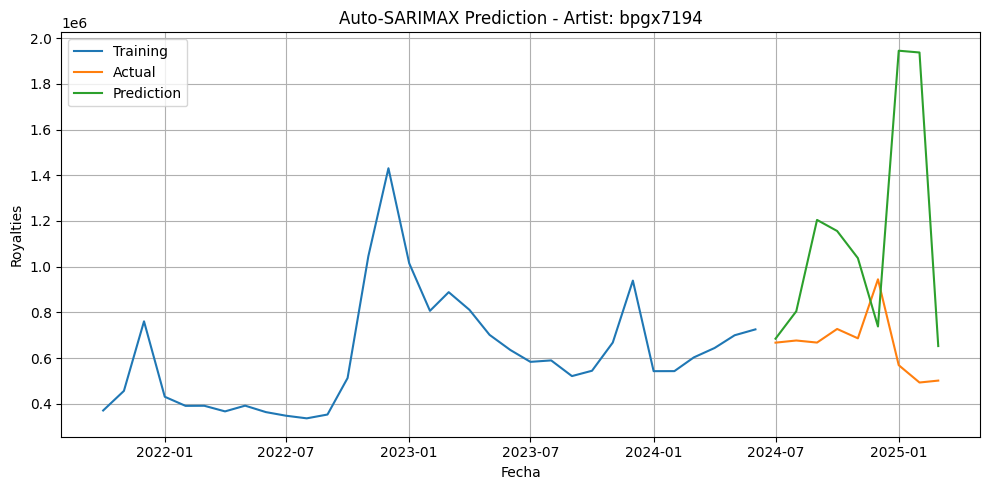

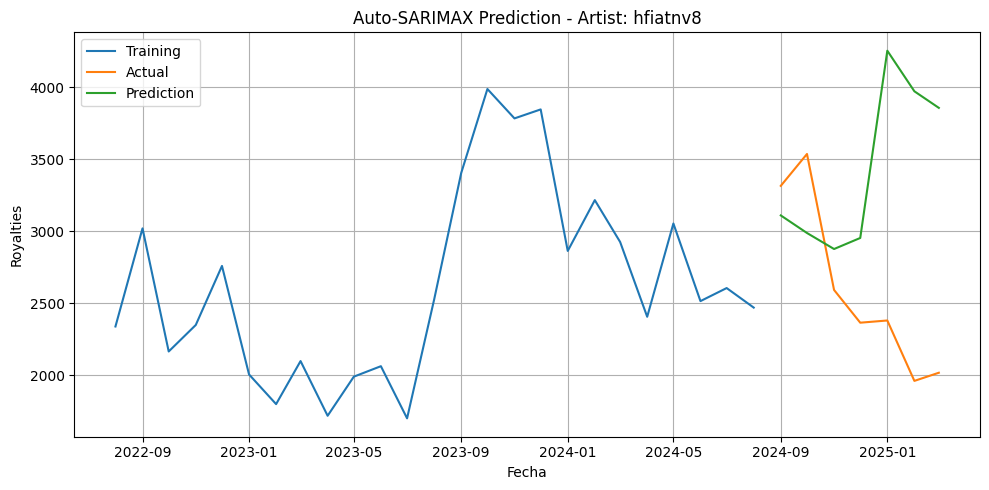

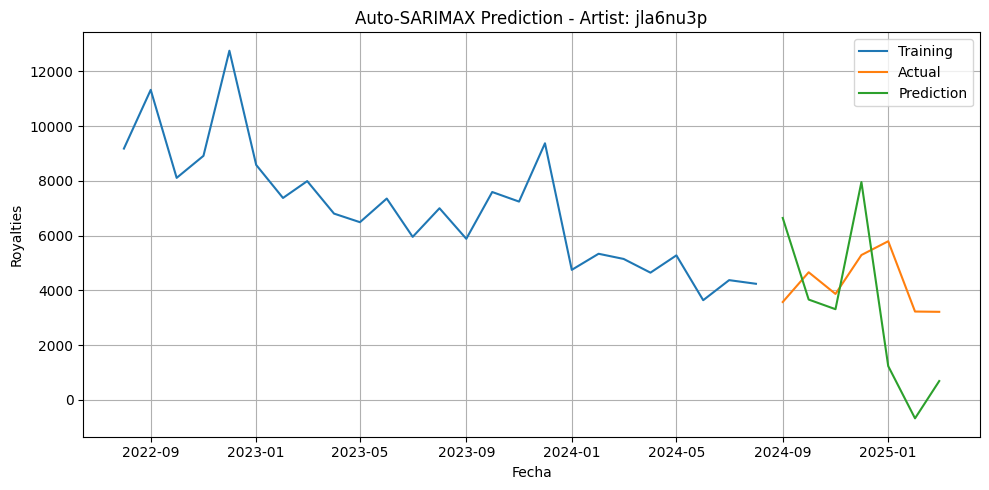

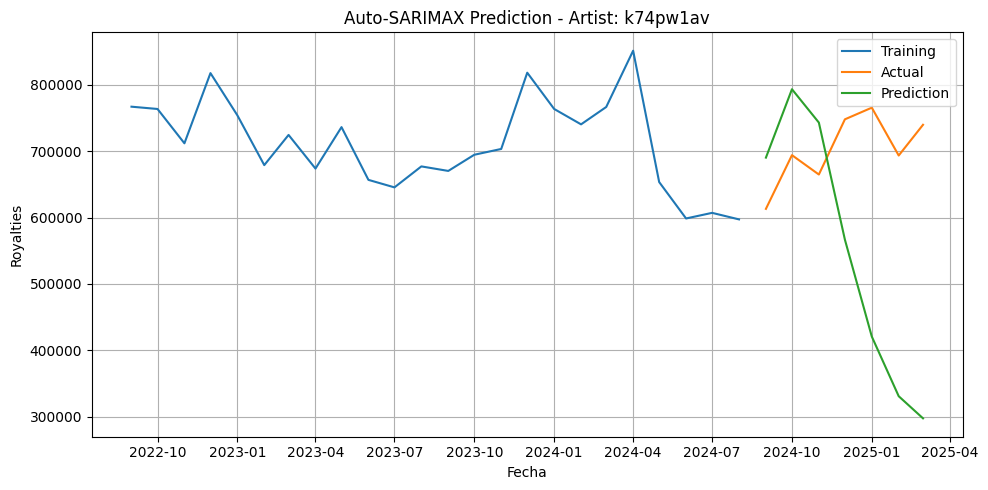

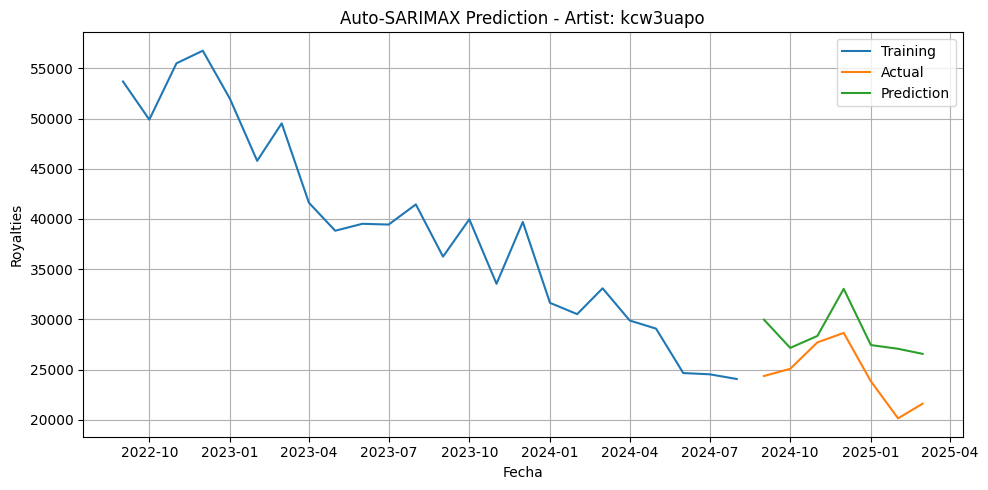

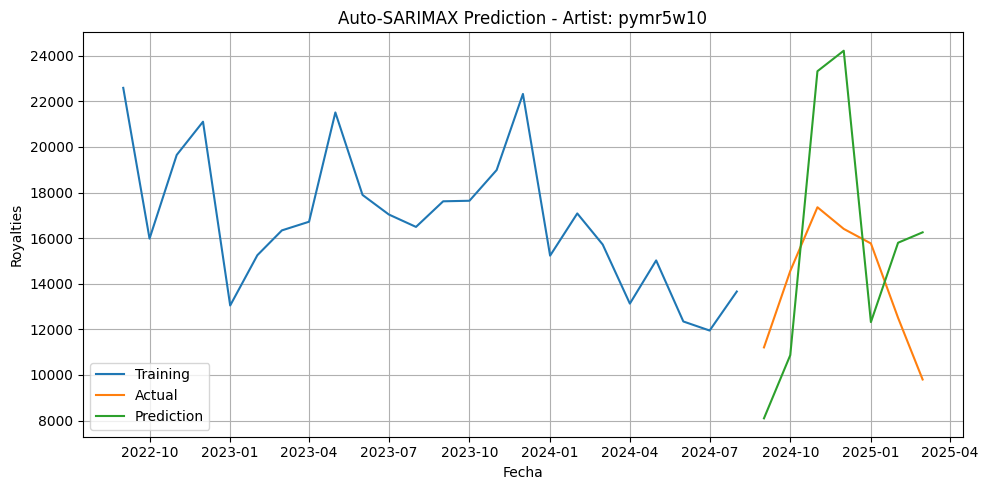

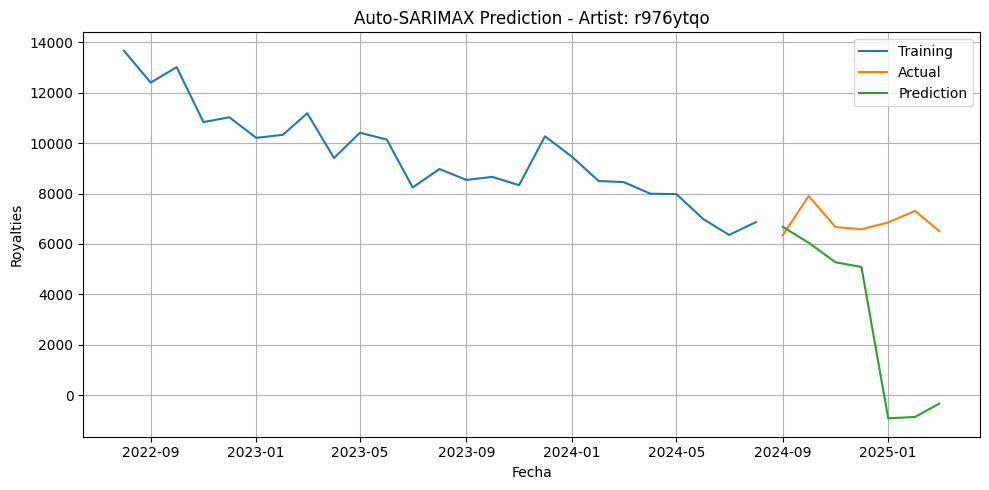

In [18]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Visualizaciones individuales por artista usando auto_arima
for artist_id, group in df.groupby("artist_id"):
    group = group.sort_values("date")
    group.set_index("date", inplace=True)

    y = group["royalties"].asfreq('MS')
    X = group[[
    "instagram_followers", 
    "twitter_followers", 
    "track_release", 
    "sentiment", 
    "mentions_followers", 
    "num_posts", 
    "num_comments", 
    "mean_royalties_6m", 
    "std_instagram_followers_6m", 
    "growth_twitter_followers", 
    "growth_instagram_followers", 
    "sum_track_releases_6m", 
    "mean_sentiment_3m", 
    "sum_mentions_followers_3m", 
    "month"
    ]].asfreq('MS')

    if len(y) < 10:
        continue

    train_size = int(len(y) * 0.8)
    y_train, y_test = y[:train_size], y[train_size:]
    X_train, X_test = X[:train_size], X[train_size:]

    try:
        # Encontrar el mejor order automáticamente
        auto_model = auto_arima(
            y_train,
            exogenous=X_train,
            seasonal=False,
            stepwise=True,
            error_action="ignore",
            suppress_warnings=True,
            trace=False
        )
        best_order = auto_model.order

        # Definir seasonal_order según cantidad de datos
        seasonal_order = (0, 0, 0, 0) if len(y_train) < 12 else (1, 0, 1, 12)

        # Ajustar SARIMAX con el mejor orden
        model = SARIMAX(y_train, exog=X_train, order=best_order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)

        forecast = model_fit.forecast(steps=len(y_test), exog=X_test)

        # Gráfico
        plt.figure(figsize=(10, 5))
        plt.plot(y_train.index, y_train, label='Training')
        plt.plot(y_test.index, y_test, label='Actual')
        plt.plot(y_test.index, forecast, label='Prediction')
        plt.title(f'Auto-SARIMAX Prediction - Artist: {artist_id}')
        plt.xlabel('Fecha')
        plt.ylabel('Royalties')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error with artist {artist_id}: {e}")
        continue


In [19]:
# Consolidate Results
results_df = pd.DataFrame(results)
results_df.to_csv("sarimax_metrics_per_artist.csv", index=False)
results_df.head()

,Artist_ID,Model,MSE,MAE,RMSE,MAPE
0,436lvfnz,SARIMAX,1.287214e+09,28829.697735,35877.761426,0.187388
1,5jwhbt0o,SARIMAX,4.378150e+07,6138.251995,6616.758662,0.507850
2,5t4iv6o3,SARIMAX,1.434247e+10,112119.755399,119760.042241,0.336492
3,65m1vtnc,SARIMAX,1.976764e+10,133194.468254,140597.433468,0.193277
4,67gc5xm9,SARIMAX,4.174349e+09,58968.899196,64609.203788,0.154696


In [20]:
# Create Final DataFrame
df_forecast_sarimax = pd.DataFrame(forecast_output)

# Save to CSV
#output_path = "sarimax_predictions_for_powerbi.csv"
#df_forecast_sarimax.to_csv(output_path, index=False)


## Forecast

In [21]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import pandas as pd

def forecast_por_artista(df, artist_id, steps=6):
    """
    Trains a SARIMAX model per artist and performs a forecast using auto_arima.

    Parameters:
    - df: General DataFrame
    - artist_id: Artist ID (songstats_artist_id)
    - steps: Months to forecast

    Returns:
    - forecast_df: DataFrame with the predictions
    - fig: Plot figure

    """
    # Filtrar y preparar los datos
    df_artista = df[df['artist_id'] == artist_id].copy()
    df_artista = df_artista.sort_values('date')
    df_artista.set_index('date', inplace=True)
    df_artista.index = pd.to_datetime(df_artista.index)
    df_artista = df_artista.asfreq('MS')

    if df_artista['royalties'].isnull().any():
        df_artista['royalties'].interpolate(method='linear', inplace=True)

    y = df_artista['royalties']

    if len(y) < 10 or y.std() == 0:
        print(f"⚠️ Artist {artist_id} has insufficient data or lacks variability.")
        return None, None

    try:
        # Automatically find the best ARIMA model
        auto_model = auto_arima(
            y,
            seasonal=False,  # Disable seasonality to allow multivariate use if needed
            stepwise=True,
            error_action="ignore",
            suppress_warnings=True,
            trace=False
        )
        best_order = auto_model.order

        # Fit the SARIMAX model without seasonality (ARIMA only)
        model = SARIMAX(y, order=best_order, seasonal_order=(0, 0, 0, 0))
        result = model.fit(disp=False)

        # Future dates
        start_date = y.index[-1] + pd.DateOffset(months=1)
        future_dates = pd.date_range(start=start_date, periods=steps, freq='MS')

        # Forecast
        predictions = result.get_forecast(steps=steps)
        mean_pred = predictions.predicted_mean
        confidence_interval = predictions.conf_int()

        # Create forecast DataFrame
        forecast_df = pd.DataFrame({
            'artist_id': artist_id,
            'prediction_date': future_dates,
            'royalties_forecast': mean_pred.values,
            'lower_ci': confidence_interval.iloc[:, 0].values,
            'upper_ci': confidence_interval.iloc[:, 1].values
        })

        # Create plot
        fig, ax = plt.subplots(figsize=(10, 5))
        y.plot(ax=ax, label='Historical')
        mean_pred.plot(ax=ax, label='Forecast', color='orange')
        ax.fill_between(future_dates, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1],
                        color='orange', alpha=0.3)
        ax.set_title(f'Royalties Forecast - Artist {artist_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Royalties')
        ax.legend()
        plt.tight_layout()
        plt.close(fig)

        return forecast_df, fig

    except Exception as e:
        print(f"❌ Error processing artist {artist_id}: {e}")
        return None, None



In [22]:
# List of unique artist IDs
artist_list = df['artist_id'].unique()

# Initialize lists to store results
forecast_list = []
figure_list = []

# Iterate over each artist and generate forecast
for artist_id in artist_list:
    forecast_df, figure = forecast_por_artista(df, artist_id, steps=6)

    if forecast_df is not None:
        forecast_list.append(forecast_df)

    if figure is not None:
        figure_list.append((artist_id, figure))

# Consolidate all valid forecasts into a single DataFrame
if forecast_list:
    consolidated_forecasts_df = pd.concat(forecast_list, ignore_index=True)
else:
    consolidated_forecasts_df = pd.DataFrame()  # empty if everything fails


Chart for artist 436lvfnz


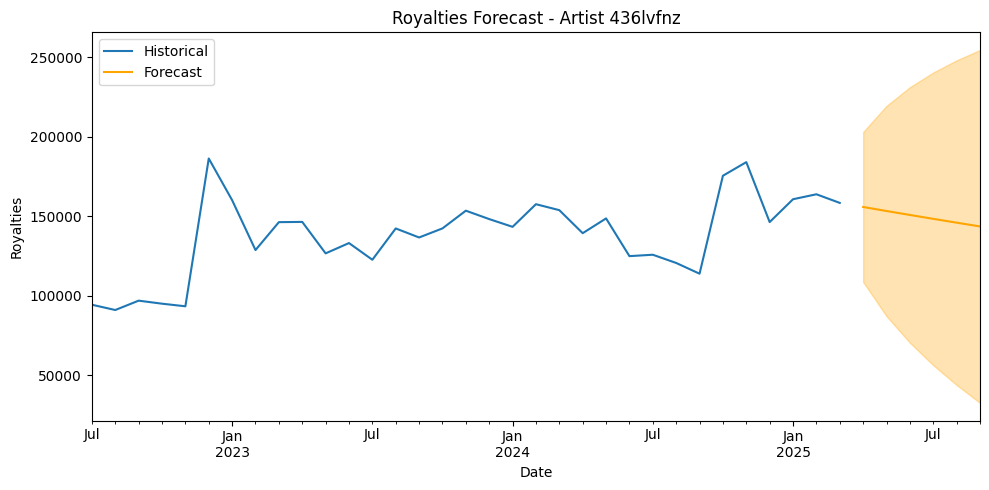

Chart for artist 5jwhbt0o


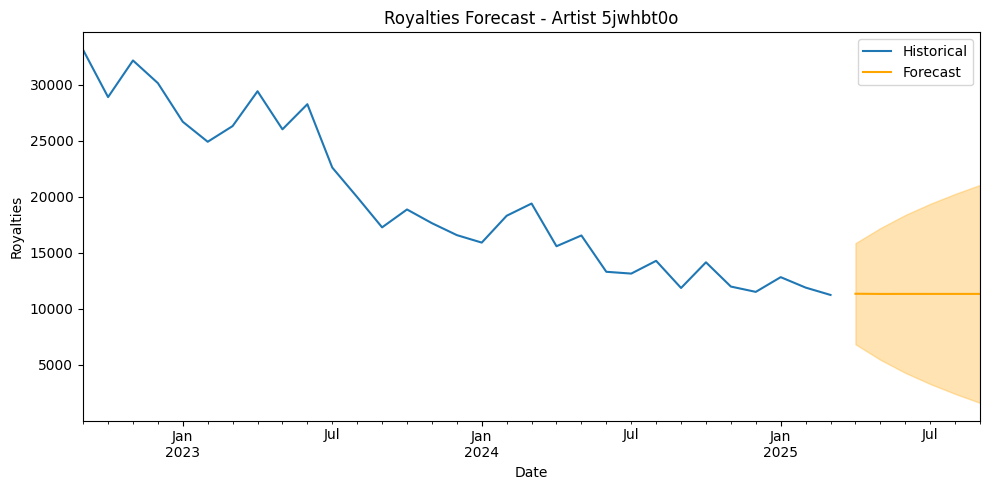

Chart for artist 5t4iv6o3


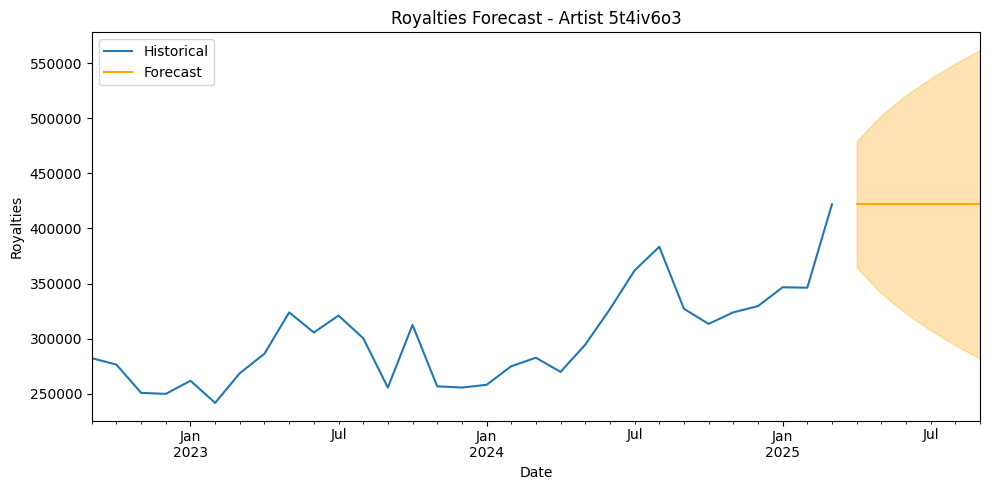

Chart for artist 65m1vtnc


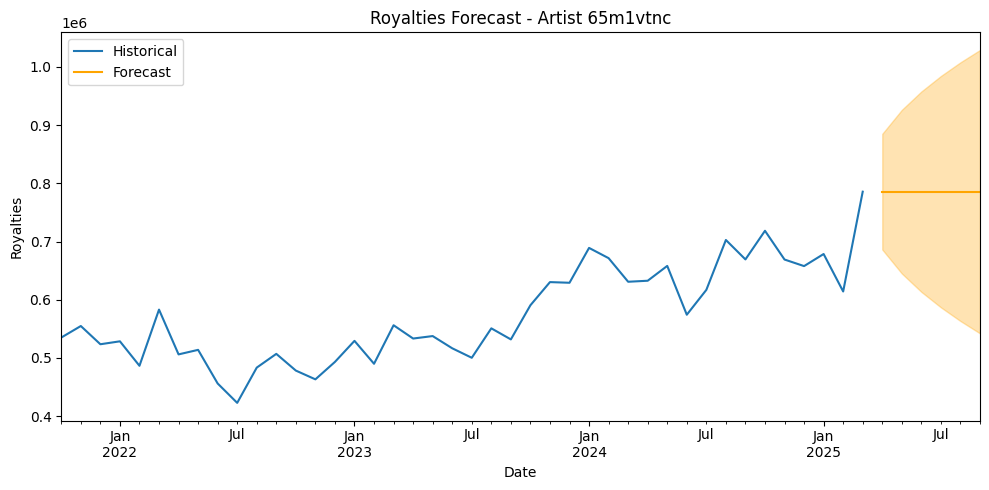

Chart for artist 67gc5xm9


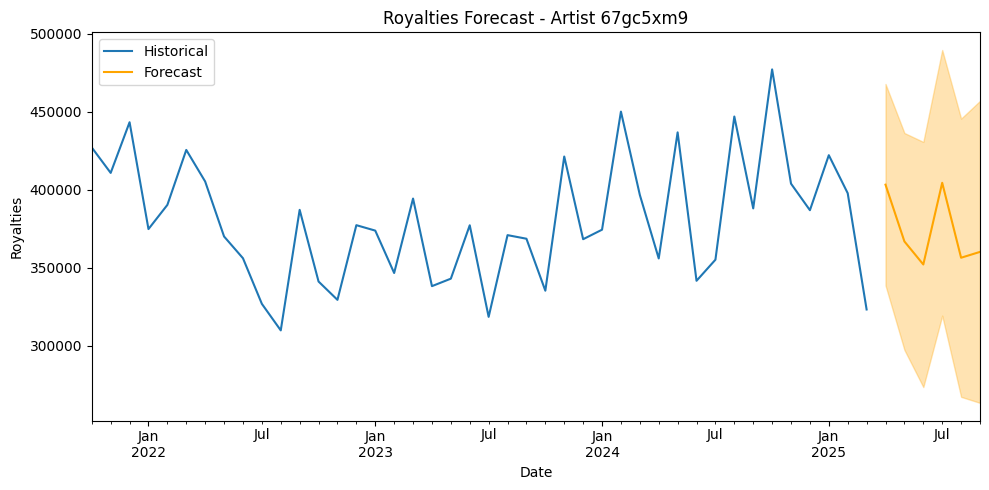

Chart for artist 6ygz70qs


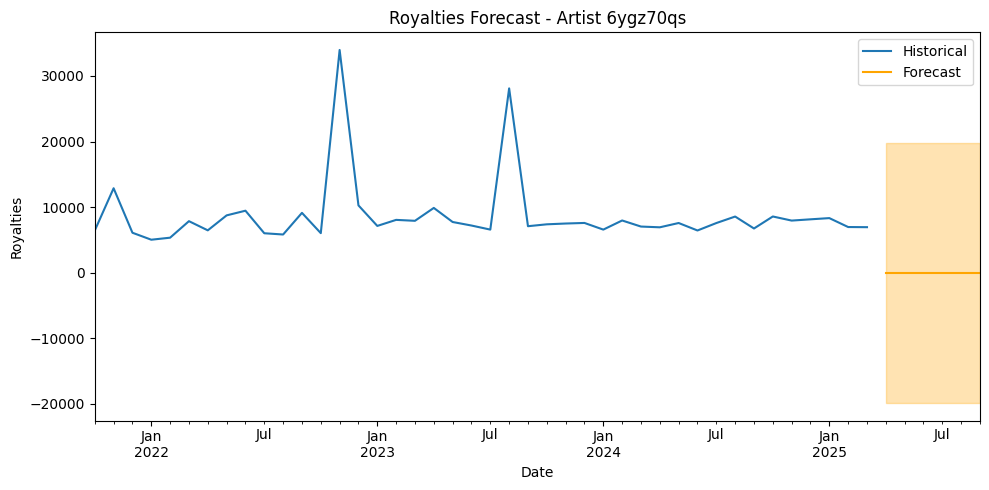

Chart for artist al0gcvtm


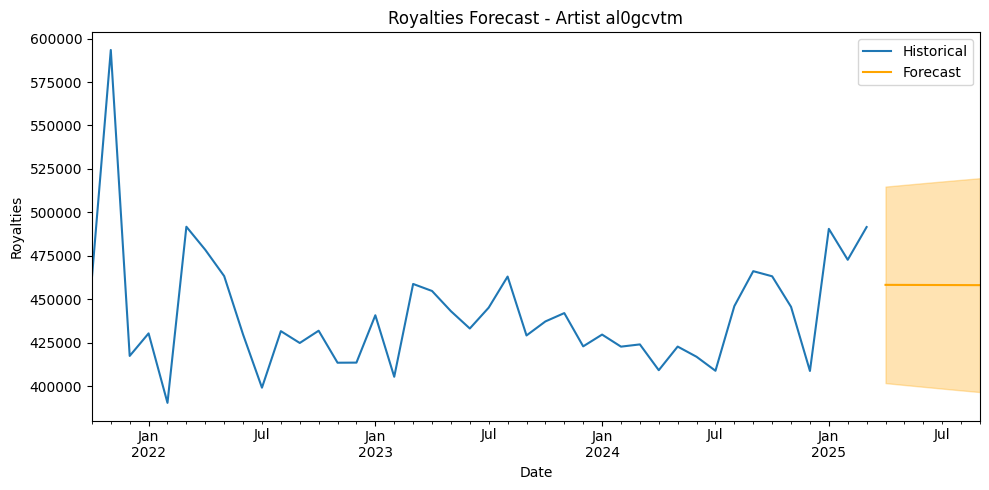

Chart for artist awrkf92m


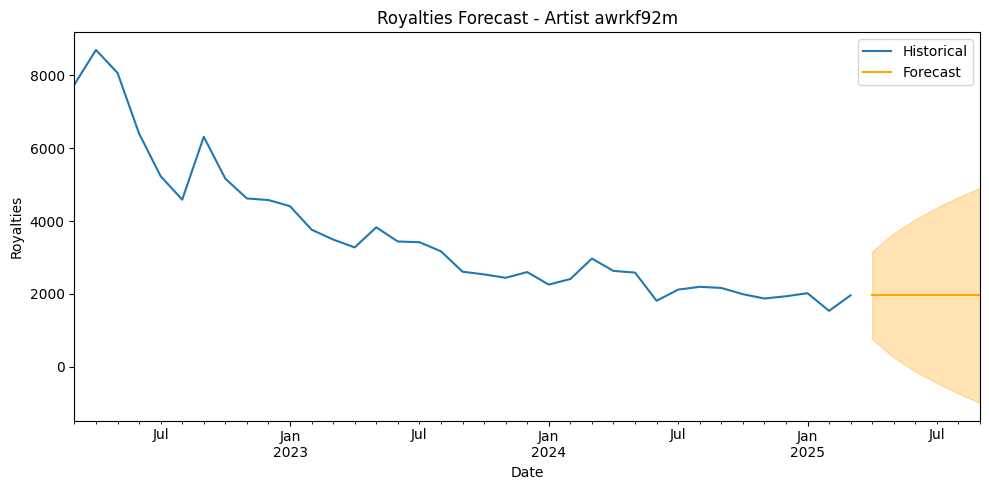

Chart for artist bpgx7194


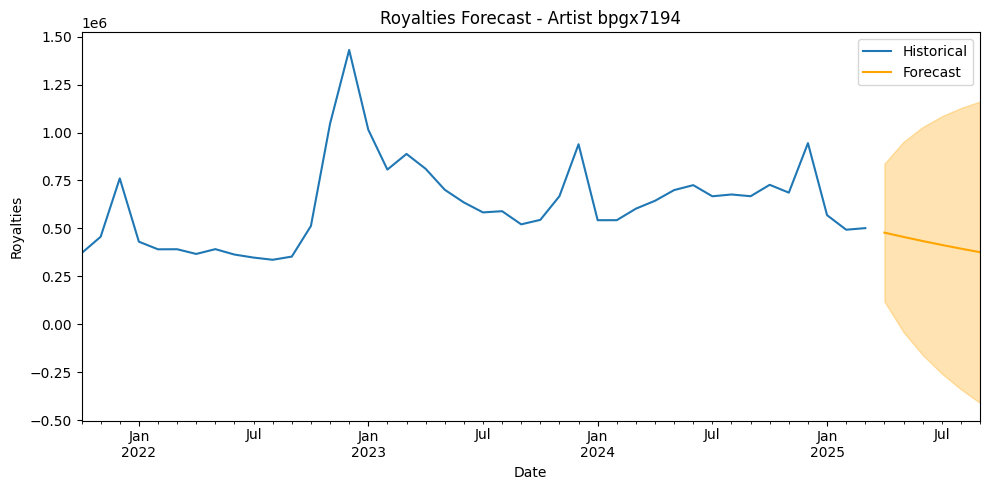

Chart for artist hfiatnv8


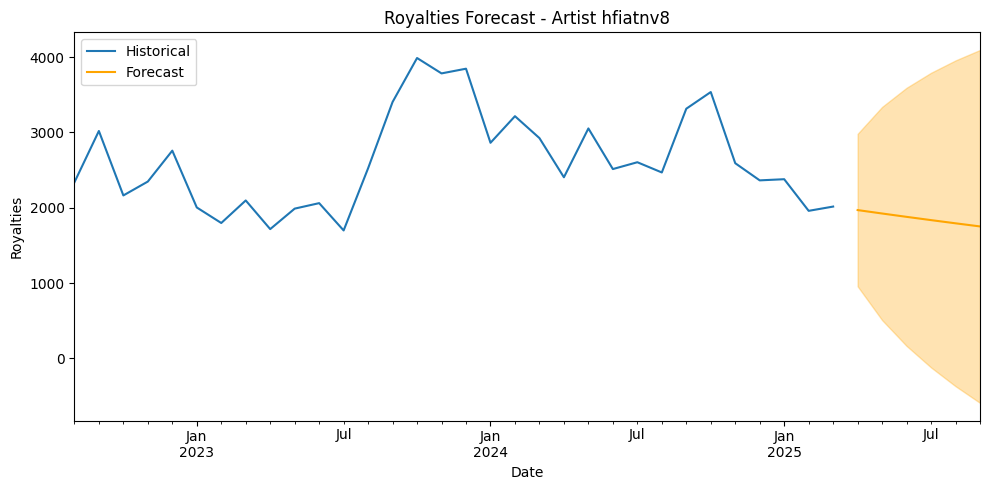

Chart for artist jla6nu3p


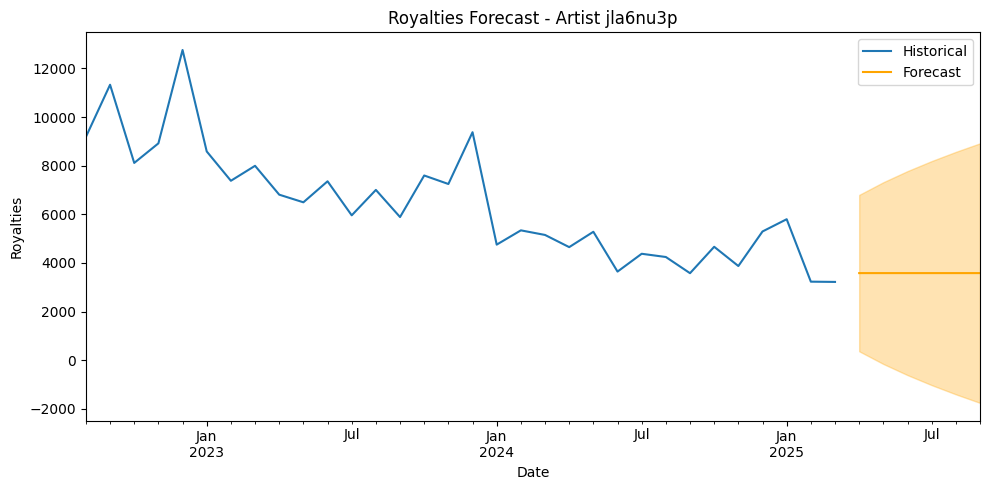

Chart for artist k74pw1av


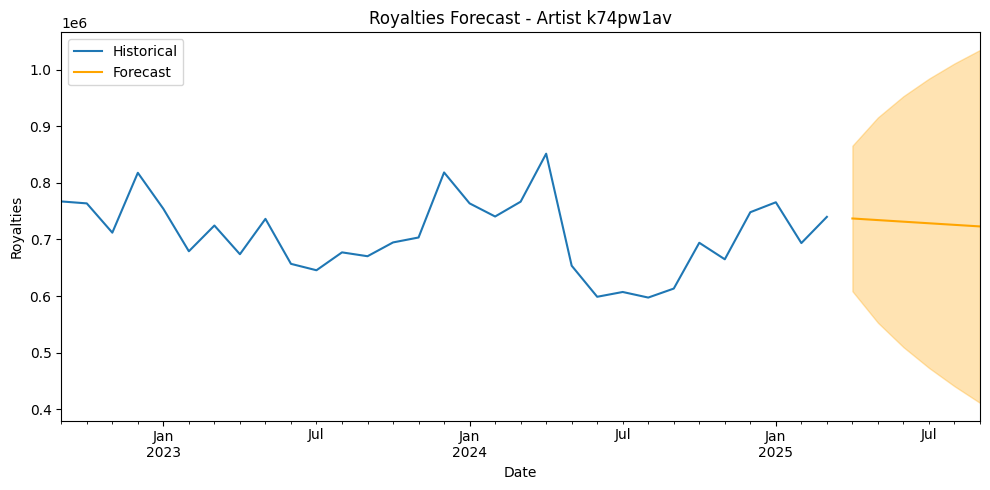

Chart for artist kcw3uapo


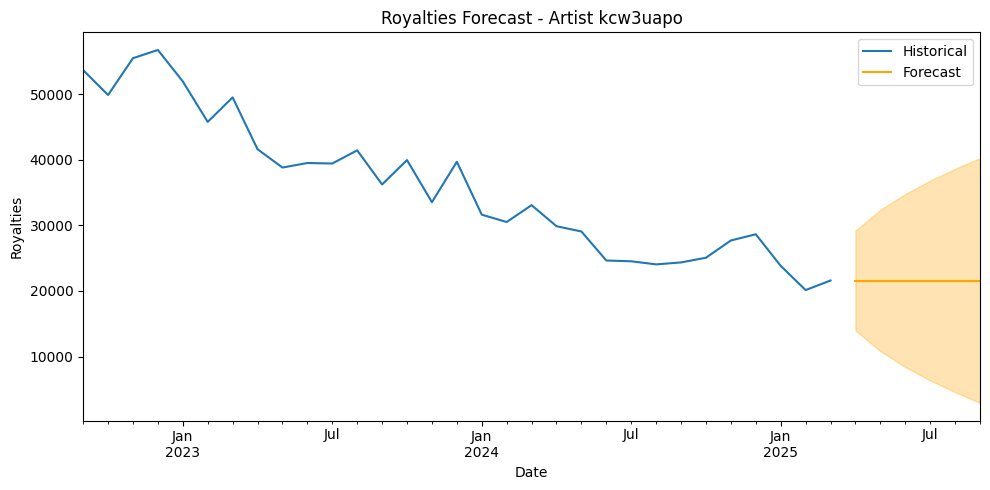

Chart for artist pymr5w10


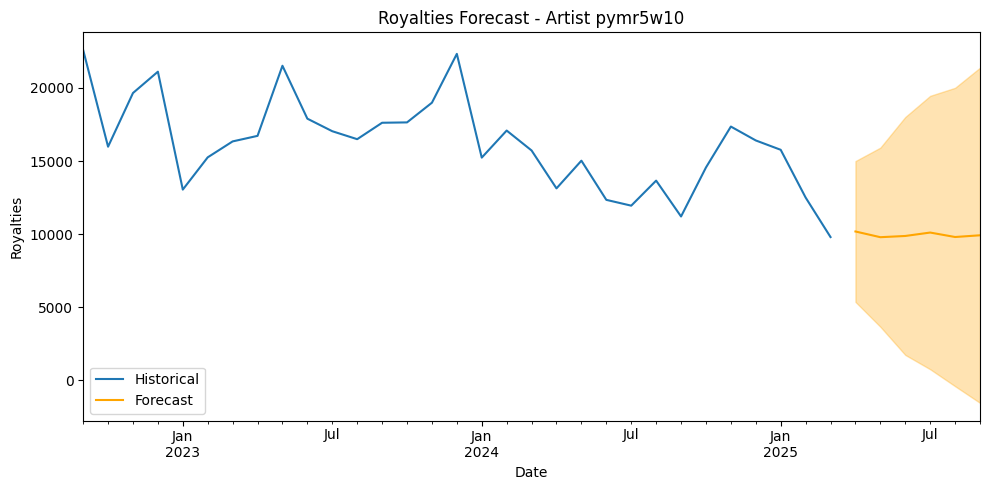

Chart for artist r976ytqo


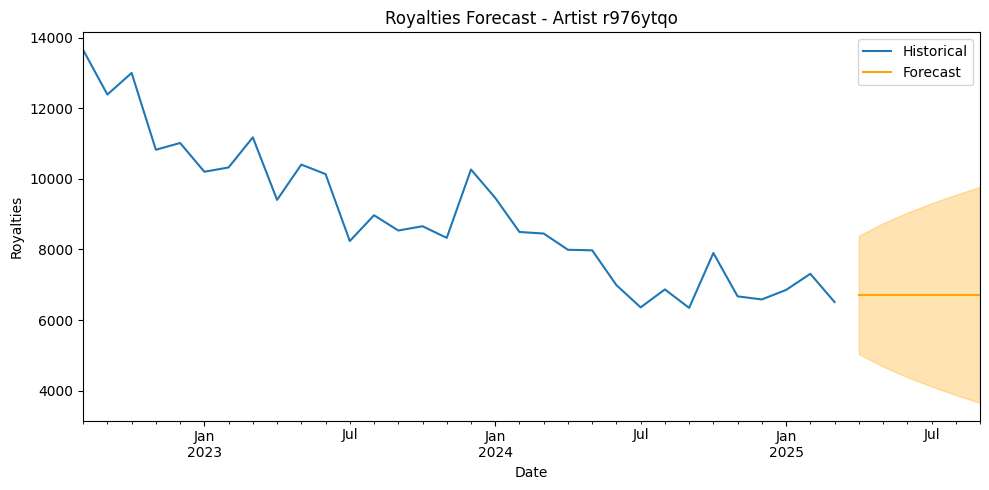

In [23]:
# Display charts
for artist_id, figure in figure_list:
    print(f"Chart for artist {artist_id}")
    display(figure)
